# 3章Policy Function Iteration

### 0. 準備

In [338]:
# ライブラリのインポート
# import math
import numpy as np
from collections.abc import Callable
from scipy.optimize import fmin

In [339]:
# 使用する関数の定義
def output(k, A, alpha):
    return A * (k ** alpha)
def wealth(k: float, 
            A:float, 
            alpha: float, 
            delta: float,
            output: Callable[[float, float, float], float]):
    return output(k, A, alpha) + (1 - delta) * k
def utility(c: float, gamma: float):
    if c < 0:
        return - 10**5 + c # 消費が負の場合のペナルティ
    if gamma == 1:
        return np.log(c)
    else: 
        return (c ** (1 - gamma)) / (1 - gamma)

# 新しい価値関数のグリッドを計算する関数
def calc_vf_new(k_grid, pf_kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old): 
    vf_new = np.zeros((k_grid.size, A.size))
    for i, K in enumerate(k_grid):
        for l, a in enumerate(A):
            C = wealth(K, a, alpha, delta, output) - pf_kprime_grid[i, l]
            for k in range(len(A)):
                expected_vf_old =+ P[l, k] * vf_old[i, k]
            vf_new[i, l] =+ utility(C, gamma) + beta * expected_vf_old
    return vf_new

# 価値関数の補間する関数
def vf_interp(k_grid, A, vf_grid): 
    def vf(k, a):
        A_index = np.where(A == a)[0][0]
        cheb_fit = np.polynomial.Chebyshev.fit(k_grid, vf_grid[:, A_index], deg = 16)
        return cheb_fit(k)
    return vf

# ベルマン方程式の右辺
def rhs_bellman(kprime_star, k ,a, A, P, alpha, beta, gamma, delta, # 変数とパラメータ
                utility, output, wealth, vf): # 必要な関数
    C = wealth(k, a, alpha, delta, output) - kprime_star
    if C < 0:
        rhs = - 10**5 + C
    else:
        A_index = np.where(A == a)[0][0]
        for k, aprime in enumerate(A):
            expected_vf =+ P[A_index, k] * vf(kprime_star, aprime)
        rhs = utility(C, gamma) + beta * expected_vf
    return - rhs
# 連続な価値関数 vf を使用してベルマン方程式の右辺を最大化する pf_kprime_grid を計算する関数
def optimize_pf(k_grid, A, P, alpha, beta, gamma, delta, # 変数とパラメータ
                utility, output, wealth, vf, rhs_bellman): # 必要な関数
    pf_kprime_grid = np.zeros((k_grid.size, A.size))
    for i, k in enumerate(k_grid): # 政策関数を求める
        for l, a in enumerate(A):
            pf_kprime_grid[i, l] = fmin(rhs_bellman, 
                                    x0 = k_grid[i], 
                                    args = (k, a, A, P, alpha, beta, gamma, delta,
                                            utility, output, wealth, vf), 
                                    disp = 0)[0]
    return pf_kprime_grid

### 1. グリッド生成

In [340]:
nk = 21
k_grid = np.linspace(0.025, 0.5, 21)
print(k_grid)

[0.025   0.04875 0.0725  0.09625 0.12    0.14375 0.1675  0.19125 0.215
 0.23875 0.2625  0.28625 0.31    0.33375 0.3575  0.38125 0.405   0.42875
 0.4525  0.47625 0.5    ]


### 2. カリブレーションしたパラメータの値を設定

In [341]:
beta = 0.96
gamma = 1.0
alpha = 0.4
delta = 1.0

### 3. 収束の基準を与える

In [342]:
epsilon = 1e-5

### 4. 確率変数 $A = \{A_{good}, A_{bad}\}$を定義

In [343]:
A = np.array([1.01, 0.99])
print(A)

[1.01 0.99]


### 5. 遷移確率行列 $P$を定義

In [344]:
P = np.array([[0.875, 0.125], [0.125, 0.875]])
print(P)

[[0.875 0.125]
 [0.125 0.875]]


### 6. 政策関数の初期値をguess

- 今回は富の関数の半分の値とする

In [345]:
kprime_grid = np.zeros((k_grid.size, A.size))
for i, k in enumerate(k_grid):
    for l, a in enumerate(A):
        kprime_grid[i, l] = wealth(k, a, alpha, delta, output) /2
print(kprime_grid)

[[0.11546953 0.113183  ]
 [0.15082774 0.14784105]
 [0.17677733 0.17327679]
 [0.19799384 0.19407317]
 [0.21625386 0.21197161]
 [0.23245266 0.22784964]
 [0.24711397 0.24222063]
 [0.26057453 0.25541463]
 [0.27306546 0.26765822]
 [0.28475328 0.2791146 ]
 [0.2957625  0.28990581]
 [0.30618899 0.30012585]
 [0.31610841 0.30984884]
 [0.32558163 0.31913447]
 [0.33465845 0.32803155]
 [0.34338026 0.33658065]
 [0.35178182 0.34481584]
 [0.35989269 0.35276611]
 [0.36773826 0.36045631]
 [0.37534045 0.36790797]
 [0.38271843 0.37513985]]


### 7. 当て推量した政策関数を用いて価値関数を計算する

In [346]:
# a. 初期の価値関数をguess
vf_old = np.zeros((k_grid.size, A.size))

diff = 1.0 + epsilon
iter_count = 0
pf_kprime_grid = np.copy(kprime_grid)

while diff > epsilon:
    iter_count += 1

    # 7b. 新たな価値観数を得る
    for loop in range(1000):
        vf_new = calc_vf_new(k_grid, pf_kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old)
        vf_old = vf_new.copy()
    # print(vf_old)
    
    # 8 得られた新しい価値関数を用いて政策関数を求める
    vf = vf_interp(k_grid, A, vf_new) # 価値関数の補間
    
    # 連続な価値関数を用いて政策関数を求める
    pf_kprime_grid = optimize_pf(k_grid, A, P, alpha, beta, gamma, delta,
                                utility, output, wealth, vf, rhs_bellman)

    # 新しい政策関数を使って新しい価値関数を計算
    vf_new = calc_vf_new(k_grid, pf_kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old)

    diff = np.max(np.abs(vf_old - vf_new)) # 収束の判定
    vf_old = vf_new.copy()
    if iter_count%1 == 0:
        print(f'iteration: {iter_count}, diff: {diff}')

iteration: 1, diff: 0.4413933605487257


/Users/hiroetomokana/Library/Caches/pypoetry/virtualenvs/quant-macro-workshop-bUjjWVNQ-py3.12/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x


iteration: 2, diff: 43.62716045850465
iteration: 3, diff: 67.38411175683268
iteration: 4, diff: 67.0964296843809
iteration: 5, diff: 43.87718197601647
iteration: 6, diff: 43.88527644230106
iteration: 7, diff: 43.88527644230102
iteration: 8, diff: 43.60554953609548
iteration: 9, diff: 43.951804432150624
iteration: 10, diff: 43.88477105686454
iteration: 11, diff: 43.88477105686456
iteration: 12, diff: 43.60554953609548
iteration: 13, diff: 43.70691439337696
iteration: 14, diff: 43.706914393376955
iteration: 15, diff: 66.30122960765807
iteration: 16, diff: 44.17220053234624
iteration: 17, diff: 44.17220053234626
iteration: 18, diff: 43.941484341038525
iteration: 19, diff: 44.17164504350441
iteration: 20, diff: 0.9358169838221044
iteration: 21, diff: 22.903073453381523
iteration: 22, diff: 64.76409290771039
iteration: 23, diff: 43.352709650365554
iteration: 24, diff: 66.23779465183046
iteration: 25, diff: 66.23779465183044
iteration: 26, diff: 44.172453129316324
iteration: 27, diff: 43.884

KeyboardInterrupt: 

In [ ]:
vf_old

### p78 図3.6の価値関数と政策関数をプロット

In [347]:
# PFIで得られた新しい価値関数から政策関数を計算する
vf = vf_interp(k_grid, A, vf_new)
kprime_grid = optimize_pf(k_grid, A, P, alpha, beta, gamma, delta,
                          utility, output, wealth, vf, rhs_bellman)

/Users/hiroetomokana/Library/Caches/pypoetry/virtualenvs/quant-macro-workshop-bUjjWVNQ-py3.12/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x


[[-2.95147905e+18 -2.95147905e+18]
 [-2.87769208e+18 -2.87769208e+18]
 [ 6.36074219e-02  6.47402344e-02]
 [ 1.10612305e-01  1.15199219e-01]
 [ 1.11187500e-01  1.15312500e-01]
 [ 1.11687012e-01  1.15393066e-01]
 [ 1.86082031e-01  1.94457031e-01]
 [ 1.86842285e-01  1.94611816e-01]
 [ 1.87453125e-01  1.94675781e-01]
 [ 1.88015625e-01  2.67567871e-01]
 [-2.90536219e+18  2.67729492e-01]
 [ 1.88746094e-01  2.67912109e-01]
 [-3.43109440e+18  2.68041016e-01]
 [-2.46264033e+18  3.48742676e-01]
 [-2.63788440e+18  3.48841797e-01]
 [-2.81312847e+18  3.49007568e-01]
 [ 4.17972656e-01  4.23984375e-01]
 [-2.37271246e+18  4.23976807e-01]
 [ 4.69910645e-01  4.70440918e-01]
 [-2.63557856e+18  4.70482910e-01]
 [ 4.69921875e-01  4.70507812e-01]]


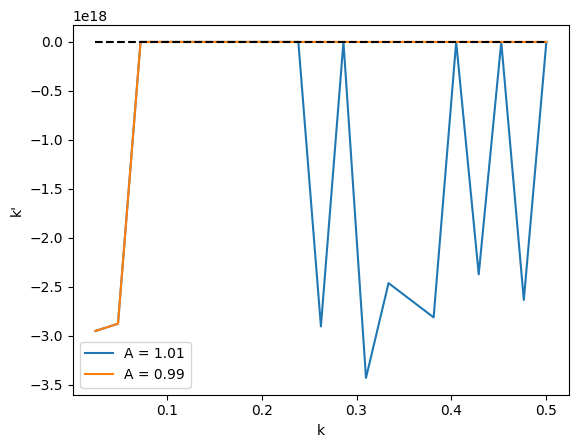

In [348]:
print(kprime_grid)
# k_grid と kprime_grid をプロット
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for l, a in enumerate(A):
    ax.plot(k_grid, kprime_grid[:, l], label = f"A = {a}")
ax.plot(k_grid, k_grid, linestyle = "--", color = "k")
ax.set_xlabel("k")
ax.set_ylabel("k'")
ax.legend()
plt.show()

In [337]:
# %reset -f

In [ ]:
iter_count
kprime_grid